<a href="https://colab.research.google.com/github/danilo-p/ml-tp-final/blob/main/ml_tp_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho Prático Final - Transferência de Aprendizado em Classificação de Imagens

Disciplina: Aprendizado de Máquina

Aluno: Danilo Pimentel de Carvalho Costa

Matrícula: 2016058077

## Introdução

O tema escolhido para o trabalho final foi Transferência de Aprendizado em Classificação de Imagens. Mais especificamente, foram comparados diferentes modelos pré-treinados no dataset ImageNet, disponíveis como "aplicações" na biblioteca Keras. O conjunto de dados utilizado para a comparação contém imagens de gatos e cachorros, e o objetivo é produzir modelos que classificam uma imagem entre estas duas categorias.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import pandas as pd

## Carregando os dados

Abaixo carregamos o conjunto de dados, disponibilizado pelo Kaggle. Este já delimita datasets para treino e para validação, que são carregados para posterior utilização nos diferentes modelos.

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


### Pré-visualização

Abaixo pode-se ver exemplos dos dados utilizados para treino dos modelos. É interessante observar que as imagens mostram cachorros e gatos em diferentes posições, ângulos, parados, em movimento, e com ou sem outros elementos (pessoas, mobília, etc).

As variações apontadas acima são importantes para evitar que os modelos aprendam características que não são relevantes para a diferenciação entre gatos e cachorros. Por exemplo, se todas as fotos de cachorros foram tiradas em um ambiente com grama, e todas as fotos de gatos foram tiradas em um sofá, o modelo poderá dar grande importância para tais fatores e não generalizar bem.

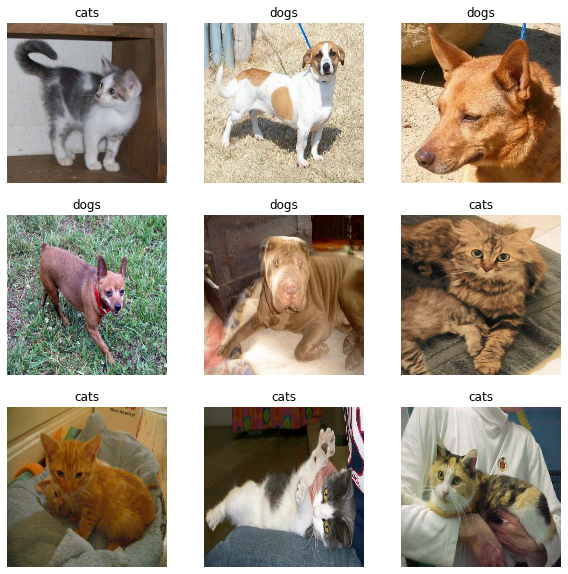

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Conjunto de teste

Como mencionado, o conjunto só delimita as partições de treino e validação. Precisamos criar um conjunto de teste para a avaliação da acurácia dos modelos. Separamos assim 20% do conjunto de validação para teste.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

### Otimização para melhor performance

Abaixo configuramos as partições de treino, validação, e testes para carregarem dados em um buffer. Assim, enquanto operações de processamento acontecem no treino, paralelamente as partições carregam dados em um buffer. Com isso, é evitada a espera de operações de I/O.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Data Augmentation

Foi utilizada a técnica de data augmentation, para enriquecer o conjunto de treino. Aqui, fazemos as operações de variação de rotação e inversão no eixo horizontal. Isso contribui para que o modelo não sofra com entradas que possuem tais pequenas variações que são irrelevantes neste problema de classificação.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

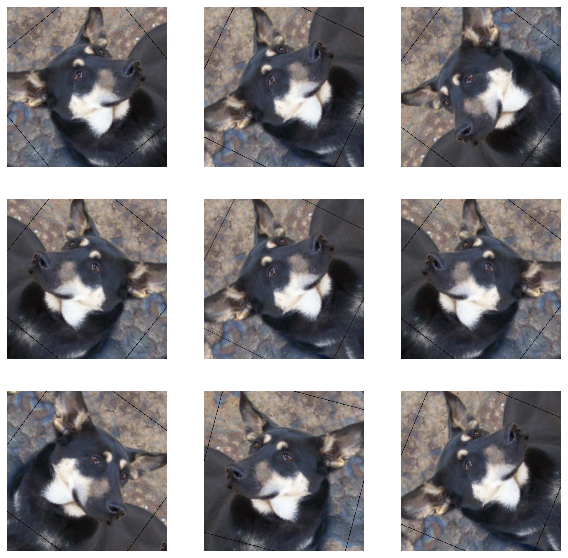

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Treinamento dos Modelos

### Modelos escolhidos

A biblioteca Keras disponibiliza vários modelos pré-treinados (https://keras.io/api/applications). Todos os modelos disponibilizados possuem pré-treino na base de dados ImageNet. Escolhemos os seguintes modelos para comparação:
- InceptionV3
- MobileNetV2
- Xception
- VGG19
- ResNet152V2

### Feature extraction

Os modelos pré-treinados serão utilizados para extrair features das imagens do conjunto de treino. O pré-treino utilizou a base de dados ImageNet, que contém mais de 1 milhão de dados e 1000 classes.

A transferência de aprendizado consiste na utilização dos pesos ajustados na rede de convolução, excluindo a última parte de classificação. Assim, são aproveitadas as "características gerais" aprendidas pelo modelo. Fixamos os pesos das camadas utilizadas para não perder o aprendizado no reajuste de pesos feito durante o treinamento do novo modelo.

Como excluímos a camada de classificação do modelo pré-treinado original, precisamos incluir uma nova. A nova camada de classificação começa com o resumo da última camada de convolução, fazendo uma média global dos filtros. Depois é configurado o dropout de 20%, que irá assinalar valores de unidades com 0 aleatoriamente durante o treino, para evitar overfitting. Ao final, é colocada uma camada densa (fully connected), que resulta em um único valor variando entre -1 e 1. valores negativos indicarão a classe 0, e valores positivos indicarão a classe 1.


### Fine-tuning

Uma etapa de fine-tuning é adicionada em todas as tentativas. O fine-tuning serve para ajustar os pesos das últimas camadas do modelo base juntamente com o treino da nova camada de classificação. Isso faz com que a acurácia do modelo final melhore, pois as últimas camadas do modelo base extraem as características mais refinadas. Ao ajustá-las, tais camadas deixam de terem um propósito genérico adiquirido a partir do ImageNet, e passam a se ajustar ao dataset de Cães e Gatos.

In [ ]:
def use_application(application, preprocess_input):
  base_model = application(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
  image_batch, label_batch = next(iter(train_dataset))
  feature_batch = base_model(image_batch)
  base_model.trainable = False

  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  feature_batch_average = global_average_layer(feature_batch)
  prediction_layer = tf.keras.layers.Dense(1)
  prediction_batch = prediction_layer(feature_batch_average)
  inputs = tf.keras.Input(shape=(160, 160, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)

  base_learning_rate = 0.0001
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  initial_epochs = 10
  loss0, accuracy0 = model.evaluate(validation_dataset)
  history = model.fit(train_dataset,
                      epochs=initial_epochs,
                      validation_data=validation_dataset)

  base_model.trainable = True
  fine_tune_at = len(base_model.layers) - 50
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate / 10),
                metrics=['accuracy'])

  fine_tune_epochs = 10
  total_epochs =  initial_epochs + fine_tune_epochs
  history_fine = model.fit(train_dataset,
                          epochs=total_epochs,
                          initial_epoch=history.epoch[-1],
                          validation_data=validation_dataset)

  return model, history, history_fine

**InceptionV3**

In [ ]:
inception_v3_model, inception_v3_history, inception_v3_history_fine = use_application(
    tf.keras.applications.InceptionV3,
    tf.keras.applications.inception_v3.preprocess_input
)

26/26 [==============================] - 2s 60ms/step - loss: 2.2916 - accuracy: 0.4926
Epoch 1/10
63/63 [==============================] - 6s 92ms/step - loss: 1.2560 - accuracy: 0.4920 - val_loss: 0.7405 - val_accuracy: 0.6188
Epoch 2/10
63/63 [==============================] - 5s 87ms/step - loss: 0.7057 - accuracy: 0.6635 - val_loss: 0.4113 - val_accuracy: 0.8168
Epoch 3/10
63/63 [==============================] - 5s 87ms/step - loss: 0.5341 - accuracy: 0.7565 - val_loss: 0.2717 - val_accuracy: 0.8923
Epoch 4/10
63/63 [==============================] - 5s 86ms/step - loss: 0.3972 - accuracy: 0.8220 - val_loss: 0.2107 - val_accuracy: 0.9121
Epoch 5/10
63/63 [==============================] - 5s 85ms/step - loss: 0.3815 - accuracy: 0.8270 - val_loss: 0.1758 - val_accuracy: 0.9270
Epoch 6/10
63/63 [==============================] - 5s 86ms/step - loss: 0.3409 - accuracy: 0.8525 - val_loss: 0.1565 - val_accuracy: 0.9394
Epoch 7/10
63/63 [==============================] - 6s 87ms/step -

**MobileNetV2**

In [ ]:
mobilenet_v2_model, mobilenet_v2_history, mobilenet_v2_history_fine = use_application(
    tf.keras.applications.MobileNetV2,
    tf.keras.applications.mobilenet_v2.preprocess_input
)

26/26 [==============================] - 1s 46ms/step - loss: 0.7414 - accuracy: 0.5124
Epoch 1/10
63/63 [==============================] - 5s 80ms/step - loss: 0.7547 - accuracy: 0.5330 - val_loss: 0.5078 - val_accuracy: 0.6881
Epoch 2/10
63/63 [==============================] - 5s 78ms/step - loss: 0.5655 - accuracy: 0.6625 - val_loss: 0.3722 - val_accuracy: 0.8082
Epoch 3/10
63/63 [==============================] - 5s 75ms/step - loss: 0.4432 - accuracy: 0.7800 - val_loss: 0.2774 - val_accuracy: 0.9047
Epoch 4/10
63/63 [==============================] - 5s 76ms/step - loss: 0.3762 - accuracy: 0.8220 - val_loss: 0.2301 - val_accuracy: 0.9208
Epoch 5/10
63/63 [==============================] - 5s 76ms/step - loss: 0.3180 - accuracy: 0.8570 - val_loss: 0.1943 - val_accuracy: 0.9406
Epoch 6/10
63/63 [==============================] - 5s 76ms/step - loss: 0.2972 - accuracy: 0.8700 - val_loss: 0.1674 - val_accuracy: 0.9493
Epoch 7/10
63/63 [==============================] - 5s 77ms/step -

**Xception**

In [ ]:
xception_model, xception_history, xception_history_fine = use_application(
    tf.keras.applications.Xception,
    tf.keras.applications.xception.preprocess_input
)

26/26 [==============================] - 2s 72ms/step - loss: 0.9092 - accuracy: 0.4196
Epoch 1/10
63/63 [==============================] - 7s 112ms/step - loss: 0.6960 - accuracy: 0.5840 - val_loss: 0.5172 - val_accuracy: 0.7661
Epoch 2/10
63/63 [==============================] - 7s 108ms/step - loss: 0.4644 - accuracy: 0.7760 - val_loss: 0.3372 - val_accuracy: 0.9097
Epoch 3/10
63/63 [==============================] - 7s 107ms/step - loss: 0.3564 - accuracy: 0.8510 - val_loss: 0.2452 - val_accuracy: 0.9406
Epoch 4/10
63/63 [==============================] - 7s 107ms/step - loss: 0.2977 - accuracy: 0.8755 - val_loss: 0.2065 - val_accuracy: 0.9468
Epoch 5/10
63/63 [==============================] - 7s 107ms/step - loss: 0.2720 - accuracy: 0.8915 - val_loss: 0.1742 - val_accuracy: 0.9554
Epoch 6/10
63/63 [==============================] - 7s 107ms/step - loss: 0.2342 - accuracy: 0.9150 - val_loss: 0.1553 - val_accuracy: 0.9567
Epoch 7/10
63/63 [==============================] - 7s 107ms

**VGG19**

In [ ]:
vgg19_model, vgg19_history, vgg19_history_fine = use_application(
    tf.keras.applications.VGG19,
    tf.keras.applications.vgg19.preprocess_input
)

26/26 [==============================] - 2s 93ms/step - loss: 4.8217 - accuracy: 0.4307
Epoch 1/10
63/63 [==============================] - 9s 138ms/step - loss: 3.9091 - accuracy: 0.5065 - val_loss: 3.0903 - val_accuracy: 0.5087
Epoch 2/10
63/63 [==============================] - 8s 129ms/step - loss: 3.0506 - accuracy: 0.5370 - val_loss: 2.4951 - val_accuracy: 0.5483
Epoch 3/10
63/63 [==============================] - 8s 130ms/step - loss: 2.4722 - accuracy: 0.5810 - val_loss: 1.9481 - val_accuracy: 0.6188
Epoch 4/10
63/63 [==============================] - 8s 130ms/step - loss: 2.0523 - accuracy: 0.6370 - val_loss: 1.4327 - val_accuracy: 0.6856
Epoch 5/10
63/63 [==============================] - 8s 130ms/step - loss: 1.8302 - accuracy: 0.6525 - val_loss: 1.1769 - val_accuracy: 0.7277
Epoch 6/10
63/63 [==============================] - 8s 130ms/step - loss: 1.6205 - accuracy: 0.6730 - val_loss: 0.9044 - val_accuracy: 0.7760
Epoch 7/10
63/63 [==============================] - 8s 130ms

**ResNet152V2**

In [ ]:
resnet_v2_model, resnet_v2_history, resnet_v2_history_fine = use_application(
    tf.keras.applications.ResNet152V2,
    tf.keras.applications.resnet_v2.preprocess_input
)

26/26 [==============================] - 3s 129ms/step - loss: 0.5003 - accuracy: 0.8020
Epoch 1/10
63/63 [==============================] - 12s 193ms/step - loss: 0.5028 - accuracy: 0.7840 - val_loss: 0.2305 - val_accuracy: 0.9072
Epoch 2/10
63/63 [==============================] - 12s 190ms/step - loss: 0.3515 - accuracy: 0.8340 - val_loss: 0.1501 - val_accuracy: 0.9369
Epoch 3/10
63/63 [==============================] - 12s 192ms/step - loss: 0.3043 - accuracy: 0.8620 - val_loss: 0.1242 - val_accuracy: 0.9505
Epoch 4/10
63/63 [==============================] - 12s 190ms/step - loss: 0.2619 - accuracy: 0.8800 - val_loss: 0.1020 - val_accuracy: 0.9629
Epoch 5/10
63/63 [==============================] - 12s 188ms/step - loss: 0.2395 - accuracy: 0.8930 - val_loss: 0.0992 - val_accuracy: 0.9592
Epoch 6/10
63/63 [==============================] - 12s 188ms/step - loss: 0.2406 - accuracy: 0.8960 - val_loss: 0.0804 - val_accuracy: 0.9678
Epoch 7/10
63/63 [==============================] - 1

## Comparação dos modelos

Após o treino dos modelos, podemos compará-los utilizando alguns critérios. As análises feitas foram das curvas de aprendizado, curvas ROC, e acurácia no conjunto de teste. Ao final, selecionamos o melhor modelo com base nos resultados.

In [ ]:
def plot_learning_curves(acc, val_acc, loss, val_loss):
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.ylim([0.8, 1])
  plt.plot([9,9],
            plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.ylim([0, 1.0])
  plt.plot([9,9],
          plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [ ]:
def evaluate_model(model, history, history_fine):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  acc += history_fine.history['accuracy']
  val_acc += history_fine.history['val_accuracy']
  loss += history_fine.history['loss']
  val_loss += history_fine.history['val_loss']

  plot_learning_curves(acc, val_acc, loss, val_loss)

  loss, accuracy = model.evaluate(test_dataset)

  image_batch, label_batch = test_dataset.as_numpy_iterator().next()
  predictions = model.predict_on_batch(image_batch).flatten()
  predictions = tf.nn.sigmoid(predictions)
  predictions = tf.where(predictions < 0.5, 0, 1)

  fpr, tpr, thresholds = roc_curve(label_batch, predictions)
  model_auc = auc(fpr, tpr)

  return fpr, tpr, thresholds, model_auc, accuracy, predictions, image_batch, label_batch

### Curvas de aprendizado

Podemos ver a evolução dos modelos ao longo das épocas de treinamento. Como mencionado anteriormente, para todos os modelos foram feitas duas fases de treinamento: extração de features e fine-tuning.

A linha verde indica o momento em que o a fase de fine-tuning começa. Em todos os modelos, podemos observar que esta foi fundamental para o melhor proveito da transferência de aprendizado. Mesmo com a má performance na primeira fase de treino observada para o modelo VGG19, a etapa de fine-tuning consegue ajustar os pesos para aumentar a acurácia de treino de menos de 80% para mais de 97%, tendo um ganho expressivo de aproximadamente 17%.

**InceptionV3**

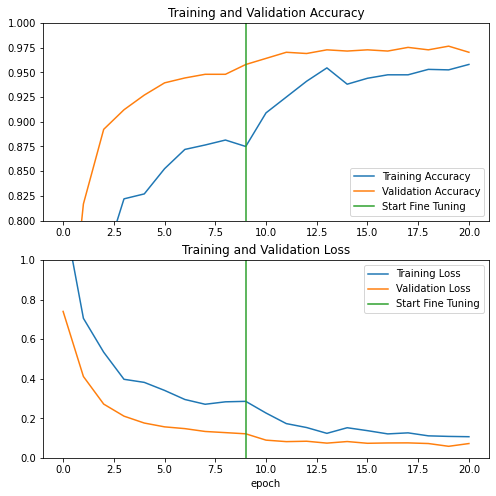

6/6 [==============================] - 0s 44ms/step - loss: 0.1158 - accuracy: 0.9479


In [ ]:
inception_v3_fpr, inception_v3_tpr, inception_v3_thresholds, inception_v3_model_auc, inception_v3_accuracy, \
inception_v3_predictions, inception_v3_image_batch, inception_v3_label_batch = evaluate_model(
    inception_v3_model,
    inception_v3_history,
    inception_v3_history_fine
)

MobileNetV2

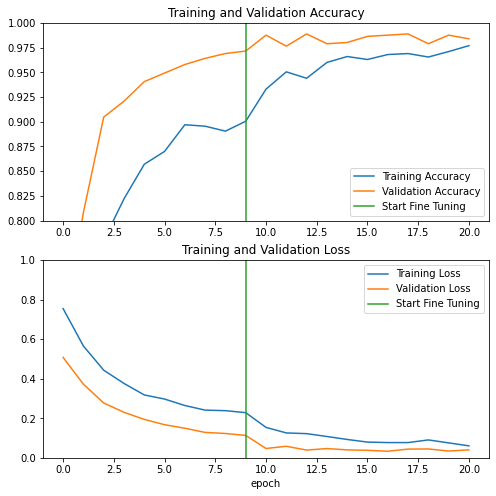

6/6 [==============================] - 0s 41ms/step - loss: 0.0634 - accuracy: 0.9740


In [ ]:
mobilenet_v2_fpr, mobilenet_v2_tpr, mobilenet_v2_thresholds, mobilenet_v2_model_auc, mobilenet_v2_accuracy, \
mobilenet_v2_predictions, mobilenet_v2_image_batch, mobilenet_v2_label_batch = evaluate_model(
    mobilenet_v2_model,
    mobilenet_v2_history,
    mobilenet_v2_history_fine
)

**Xception**

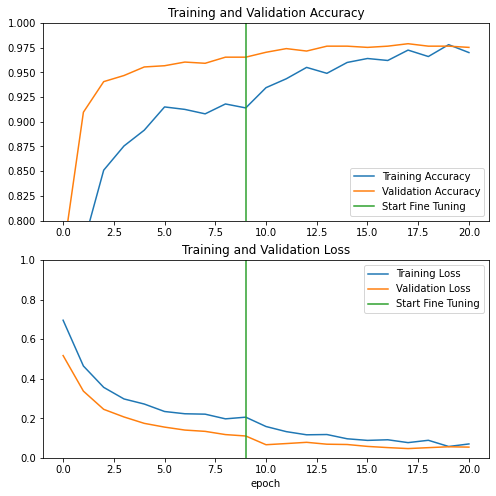

6/6 [==============================] - 0s 64ms/step - loss: 0.0443 - accuracy: 0.9844


In [ ]:
xception_fpr, xception_tpr, xception_thresholds, xception_model_auc, xception_accuracy, \
xception_predictions, xception_image_batch, xception_label_batch = evaluate_model(
    xception_model,
    xception_history,
    xception_history_fine
)

**VGG19**

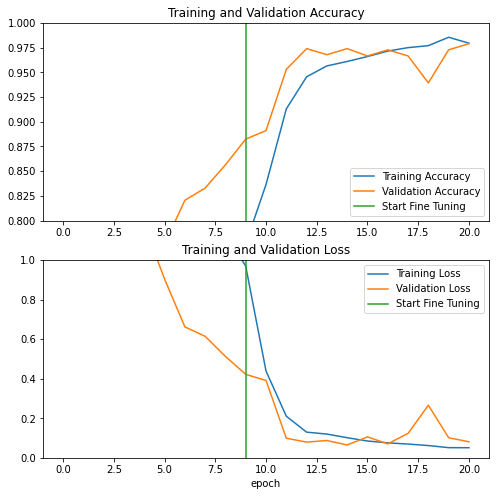

6/6 [==============================] - 0s 69ms/step - loss: 0.1003 - accuracy: 0.9740


In [ ]:
vgg19_fpr, vgg19_tpr, vgg19_thresholds, vgg19_model_auc, vgg19_accuracy, \
vgg19_predictions, vgg19_image_batch, vgg19_label_batch = evaluate_model(
    vgg19_model,
    vgg19_history,
    vgg19_history_fine
)

**ResNet152V2**

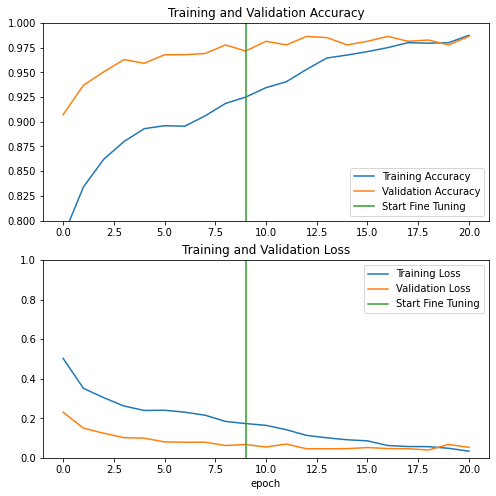

6/6 [==============================] - 1s 104ms/step - loss: 0.1302 - accuracy: 0.9740


In [ ]:
resnet_v2_fpr, resnet_v2_tpr, resnet_v2_thresholds, resnet_v2_model_auc, resnet_v2_accuracy, \
resnet_v2_predictions, resnet_v2_image_batch, resnet_v2_label_batch = evaluate_model(
    resnet_v2_model,
    resnet_v2_history,
    resnet_v2_history_fine
)

### Avaliação de acurácia

A seguir comparamos as acurácias dos modelos treinados. Podemos ver que o modelo gerado a partir da Xception teve maior acurácia. Porém, é importante observar que os outros modelos não tiveram diferença relevante.

A pequena diferença entre as acurácias dos modelos mostra que a técnica de transferência de aprendizado é poderosa. Mesmo com diferentes algoritmos, os modelos pré-treinados conseguem aprender características gerais do dataset ImageNet, e conseguimos transferir com sucesso tal aprendizado para o problema Gato vs. Cachorro.

In [ ]:
pd.DataFrame([
  '{:.4f} %'.format(inception_v3_accuracy),
  '{:.4f} %'.format(mobilenet_v2_accuracy),
  '{:.4f} %'.format(xception_accuracy),
  '{:.4f} %'.format(vgg19_accuracy),
  '{:.4f} %'.format(resnet_v2_accuracy),
], index=[
  'InceptionV3',
  'MobileNetV2',
  'Xception',
  'VGG19',
  'ResNet152V2',
], columns=['Acurácia'])

,Acurácia
InceptionV3,0.9479 %
MobileNetV2,0.9740 %
Xception,0.9844 %
VGG19,0.9740 %
ResNet152V2,0.9740 %


### Curva ROC

Aqui realisamos a análise ROC, em conjunto com a métrica AUC. É notada uma diferença com relação a análise de acurácia. O modelo VGG19 possui o maior AUC, sendo 1. Novamente, confirmamos o fato descrito acima, devido à pequena diferença e boa performance de todos os modelos em diferentes análises.

In [ ]:
def plot_roc_curves(model_roc_data):
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')

  for model_name, fpr, tpr, model_auc in model_roc_data:
    plt.plot(fpr, tpr, label='{} (AUC = {:.3f})'.format(model_name, model_auc))

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

  # Zoom in view of the upper left corner.
  plt.figure(2)
  plt.xlim(-0.05, 0.2)
  plt.ylim(0.8, 1.05)
  plt.plot([0, 1], [0, 1], 'k--')

  for model_name, fpr, tpr, model_auc in model_roc_data:
    plt.plot(fpr, tpr, label='{} (AUC = {:.3f})'.format(model_name, model_auc))

  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve (zoomed in at top left)')
  plt.legend(loc='best')
  plt.show()

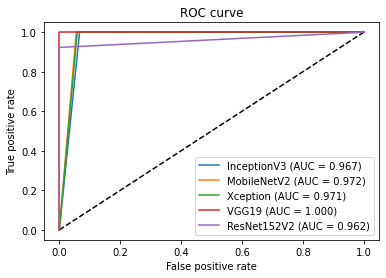

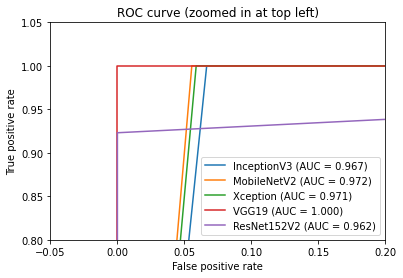

In [ ]:
plot_roc_curves([       
  ('InceptionV3', inception_v3_fpr, inception_v3_tpr, inception_v3_model_auc),
  ('MobileNetV2', mobilenet_v2_fpr, mobilenet_v2_tpr, mobilenet_v2_model_auc),
  ('Xception', xception_fpr, xception_tpr, xception_model_auc),
  ('VGG19', vgg19_fpr, vgg19_tpr, vgg19_model_auc),
  ('ResNet152V2', resnet_v2_fpr, resnet_v2_tpr, resnet_v2_model_auc)
])

### Seleção final

A escolha final foi pelo modelo Xception, que obteve maior acurácia no conjunto de teste. Porém, a diferença da acurácia para os outros modelos não foi grande, mostrando que todos tem grande potencial de generalização.

In [ ]:
def plot_predictions(predictions, image_batch):
    plt.figure(figsize=(10, 10))
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image_batch[i].astype("uint8"))
      plt.title(class_names[predictions[i]])
      plt.axis("off")

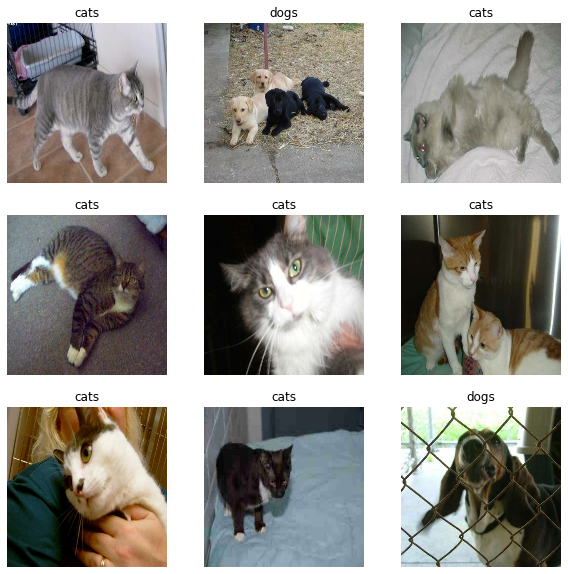

In [ ]:
plot_predictions(xception_predictions, xception_image_batch)

## Conclusão

Pudemos ver a eficácia do modelo pré-treinado Xception, que foi o modelo pré-treinado com melhor performance no conjunto de teste. Apesar disso, os outros modelos pré-treinados não tiveram diferença de performance drástica. Caso o objetivo deste trabalho fosse o treinamento do melhor modelo de classificação para este dataset, uma busca por hiperparâmetros melhores para os algoritmos seria necessária.

Percebe-se também as vantagens da transferência de aprendizado. Com esta técnica, conseguimos acurácias satisfatórias com diversos modelos pré-treinados em um grande dataset. Sem tal técnica, não conseguiriamos atingir este patamar, pois o conjunto de dados não teria imagens suficiente para fazer o algoritmo convergir.

## Referências

* https://www.tensorflow.org/tutorials/images/transfer_learning
* https://www.tensorflow.org/guide/keras/transfer_learning
* https://keras.io/api/applications/
* https://keras.io/api/applications/xception/
* https://keras.io/api/applications/vgg/#vgg19-function
* https://keras.io/api/applications/resnet/#resnet152v2-function
* https://keras.io/api/applications/inceptionv3/
* https://keras.io/api/applications/mobilenet/#mobilenetv2-function
* https://www.kaggle.com/c/dogs-vs-cats/overview
* https://www.dlology.com/blog/simple-guide-on-how-to-generate-roc-plot-for-keras-classifier/


